# Customer Segmentation

## Overview
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail is a transnational data set</a> which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## Business Goal
We aim to segement the Customers based on RFM so that the company can target its customers efficiently.

#### The steps are broadly divided into:

1. [Step 1: Reading and Understanding the Data](#1)
1. [Step 2: Data Cleansing](#2)
1. [Step 3: Data Preparation](#3)
1. [Step 4: Model Building](#4)
1. [Step 5: Final Analysis](#5)

<a id='1'></a>
## 1. Reading and Understanding the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.cluster  import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("datasets/OnlineRetail.csv")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
df.shape

(541909, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


<a id="2"></a>
## 2. Data Cleansing

Calculating missing values contribution in dataframe

In [6]:
(df.isnull().sum()/df.shape[0])*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

Dropping rows having missing values

In [7]:
df = df.dropna()
df.shape

(406829, 8)

Changing the CustomerID datatype as per business understanding

In [8]:
df['CustomerID'] = df['CustomerID'].astype('str')

In [9]:
df['CustomerID'].dtypes

dtype('O')

In [10]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


<a id="3"></a>
## 3. Data Preparation 

#### We are going to analysis the Customers based on below 3 factors:
- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [11]:
# New Attribute : Monetary

df['Amount'] = df['Quantity']*df['UnitPrice']

#Grouping Customer's ID and computing total amount spend
df_m = df.groupby('CustomerID')['Amount'].sum()

#Resetting Index
df_m = df_m.reset_index()
df_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [12]:
# New Attribute : Frequency

#Grouping Customer's ID and computing total amount spend
df_f = df.groupby('CustomerID')['InvoiceNo'].count()

#Resetting Index
df_f = df_f.reset_index()
df_f.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


Merging the two dataframes

In [13]:
rfm = pd.merge(df_m,df_f, how='inner',on='CustomerID')
rfm.head()

,CustomerID,Amount,InvoiceNo
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [14]:
# New Attribute : Recency

#Convert to datetime to proper datatype
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format = "%d-%m-%Y %H:%M")

In [15]:
# Compute the maximum date to know the last transaction date
# (Last Transaction made)
max_date = max(df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [16]:
# Computing the difference between max date and transaction date
# And assigning to a newer column: "Diff"

df['Diff'] = max_date - df['InvoiceDate']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [17]:
# Compute last transaction date to get the recency of customers

df_r = df.groupby('CustomerID')['Diff'].min()

#Resetting Index
df_r = df_r.reset_index()
df_r.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [18]:
# Extract number of days only

df_r['Diff'] = df_r['Diff'].dt.days
df_r.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [19]:
# Merge tha dataframes to get the final RFM dataframe

rfm = pd.merge(rfm, df_r, how='inner')
rfm.columns = ['CustomerID','Amount','Frequency','Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


RFM is what we have finally got into our dataset

Text(0.5, 0, 'Attributes')

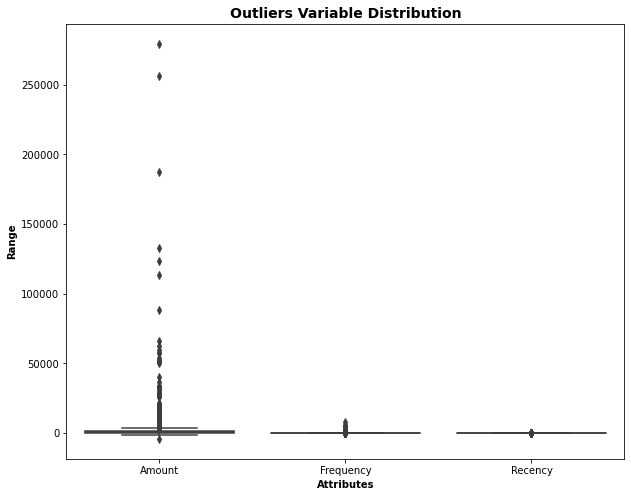

In [20]:
# Outlier Analysis of Amount Frequency and Recency
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[['Amount','Frequency','Recency']])
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [21]:
# pd.quantile(): Return values at the given quantile over requested axis.

# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

### Rescaling the Attributes

In [22]:
# Rescaling the attributes

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_scaled = scaler.fit_transform(rfm[['Amount','Frequency','Recency']])
rfm_scaled = pd.DataFrame(rfm_scaled)
rfm_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_scaled.head()

,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


<a id="4"></a>
## 4. Model Building

### K-Means Clustering

In [23]:
kmeans = KMeans(n_clusters = 4, max_iter=50)
kmeans.fit(rfm_scaled)

KMeans(max_iter=50, n_clusters=4)

In [24]:
kmeans.labels_

array([2, 3, 0, ..., 2, 0, 0])

#### Finding the Optimal Number of Clusters

##### Elbow Method

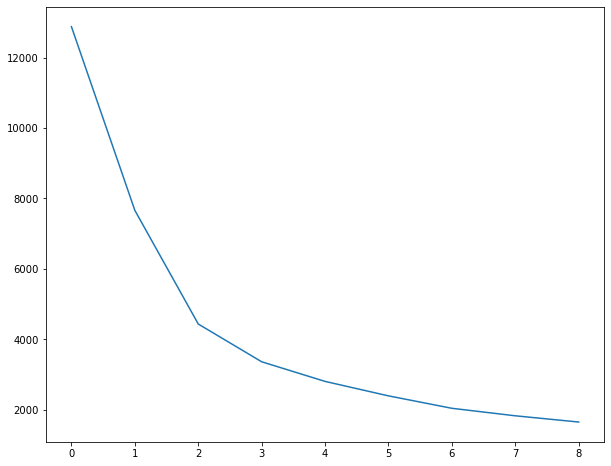

In [25]:
ssd = []

for num_clusters in range(1,10):
    kmeans = KMeans(n_clusters = num_clusters, max_iter=50)
    kmeans.fit(rfm_scaled)
    ssd.append(kmeans.inertia_)
    
plt.plot(ssd)

Therefore our optimal cluster is 2

In [26]:
# Final model with k=2
kmeans = KMeans(n_clusters=2, max_iter=50)
kmeans.fit(rfm_scaled)

KMeans(max_iter=50, n_clusters=2)

In [27]:
kmeans.labels_

array([0, 1, 0, ..., 0, 0, 0])

In [28]:
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,0


In [29]:
rfm[rfm['Cluster_Id'] == 0].describe()

,Amount,Frequency,Recency,Cluster_Id
count,3658.000000,3658.000000,3658.000000,3658.0
mean,725.632008,45.754784,104.707764,0.0
std,682.641449,41.903750,103.860222,0.0
min,-4287.630000,1.000000,0.000000,0.0
25%,245.277500,14.000000,22.000000,0.0
50%,499.135000,31.000000,63.000000,0.0
75%,1004.175000,65.000000,171.000000,0.0
max,4464.100000,262.000000,373.000000,0.0


In [30]:
rfm[rfm['Cluster_Id'] == 1].describe()

,Amount,Frequency,Recency,Cluster_Id
count,635.000000,635.000000,635.000000,635.0
mean,4408.684299,260.261417,22.503937,1.0
std,2568.927871,136.625444,32.857515,0.0
min,576.300000,4.000000,0.000000,1.0
25%,2665.435000,164.000000,3.000000,1.0
50%,3693.810000,229.000000,11.000000,1.0
75%,5451.565000,325.500000,29.000000,1.0
max,13677.590000,718.000000,305.000000,1.0


<a id="5"></a> <br>
## 5. Final Analysis

### Inference:
**K-Means Clustering with 3 Cluster Ids**
- Customers with Cluster Id 0 are the customers with high amount of transactions as compared to other customers.
- Customers with Cluster Id 0 are frequent buyers.
- Customers with Cluster Id 1 are not recent buyers and hence least of importance from business point of view.